### Reprojecting images

Create an image in ra,dec space (ICRS) and project into a parallax corrected space (EBD). Parallax will assume a distance for the candiate asteroid.

Test with a pixel-by-pixel transform and then using an affine transformation of the WCS for the image (i.e. solve for the EBD positions of the corners of the ICRS images)


In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata.utils import Cutout2D
from astropy.nddata import NDData
from astropy.nddata import CCDData
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.time import Time
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.wcs.utils import fit_wcs_from_points

from astropy.coordinates import (
    ICRS,
    GCRS,
    GeocentricTrueEcliptic,
    HeliocentricTrueEcliptic,
    solar_system_ephemeris,
    EarthLocation,
    angular_separation
)

In [2]:
# define the correction for parallax 
from scipy.optimize import minimize

def correct_parallax4(icrs, obstime, point_on_earth, guess_distance):
    ''' Calculate the parallax corrected postions for a given object at a given time and distance'''
    loc = (
        point_on_earth.x.to(u.m).value, 
        point_on_earth.y.to(u.m).value, 
        point_on_earth.z.to(u.m).value
    )*u.m
        
    # line of sight from earth to the object, 
    # the object has an unknown distance from earth
    los_earth_obj = icrs.transform_to(
        GCRS(
            obstime=obstime, 
            obsgeoloc=loc
        )
    )
    
    cost = lambda d: np.abs(guess_distance - GCRS(
        ra=los_earth_obj.ra,
        dec=los_earth_obj.dec,
        distance=d*u.AU,
        obstime=obstime, 
        obsgeoloc=loc
    ).transform_to(ICRS()).distance.to(u.AU).value)

    bounds = (guess_distance-2, guess_distance+2)
    fit = minimize(
        cost,
        (guess_distance, ),
        #tol=1e11,
        #bounds=(bounds,),
    )

    answer = GCRS(
        ra=los_earth_obj.ra,
        dec=los_earth_obj.dec,
        distance=fit.x[0]*u.AU,
        obstime=obstime, 
        obsgeoloc=loc
    ).transform_to(ICRS())
    
    return answer

def create_image(ra, dec, nx=20, ny=20, site='ctio', time="2023-03-20T16:00:00", source_separation=9, 
                 psf_sigma_x=1, psf_sigma_y=1):
    '''Create an image and WCS with a grid of point sources'''

    # Set observatory
    with solar_system_ephemeris.set('de432s'):
        loc = EarthLocation.of_site(site)

    # create ICRS image
    nx = nx
    ny = ny
    data = np.zeros((nx,ny))

    obstime = Time(time, format="isot", scale="utc")

    # define source grid and convolve with psf
    if source_separation != None:
        data[::source_separation,::source_separation] = 1
        gauss = Gaussian2DKernel(x_stddev=psf_sigma_x, y_stddev=psf_sigma_y)
        data_conv = convolve(data, gauss)
    else:
        data_conv = data

    #create WCS and pointing
    ra = ra
    dec = dec
    wcs = WCS(naxis=2)
    wcs.pixel_shape = (nx,ny)
    wcs.wcs.crpix = [nx/2,ny/2]
    #hardwired pixel scale
    wcs.wcs.cdelt = np.array([-0.000055555555556,0.000055555555556])
    wcs.wcs.crval = [ra, dec]
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

    image = CCDData(data_conv, unit="adu")
    image.wcs = wcs

    return image

# Calculate EBD WCS given ICRS WCS and distance
def fit_wcs(icrs, distance, obstime, loc):
    '''Return a WCS for the EBD images from ICRS plus parallax transform'''

    nx,ny = icrs.data.shape
    #find ra,dec corners of image and project to ebd
    icrs_corners = icrs.wcs.calc_footprint() 
    icrs_corners_coord = ICRS(icrs_corners[:,0]*u.deg, icrs_corners[:,1]*u.deg)

    eds_corner_coords = []
    for _coord in icrs_corners_coord:
        eds_corner_coords.append(correct_parallax4(_coord, obstime, loc, distance))
    eds_corner_coords = SkyCoord(eds_corner_coords)

    #define x, y for corners and fit wcs
    xy = (np.array([0,0,nx,nx]), np.array([0,ny,ny,0]))
    world_coords = eds_corner_coords
    ebd_wcs = fit_wcs_from_points(xy, world_coords, proj_point='center', projection='TAN', sip_degree=None)
    return ebd_wcs

# calculate affine transform
def fit_affine_transform(icrs, ebd, obstime, loc, distance):
    '''Fit and return an affine transform between ICRS and EBD images'''
    # https://stackoverflow.com/questions/20546182/how-to-perform-coordinates-affine-transformation-using-python-part-2
    # https://gist.github.com/jclosure/b98918f8b02a1a6c7fe760822acb07d2

    #extract corners of ICRS image and their celestial coordinates
    world = icrs.wcs.wcs_pix2world(np.array([[0, 0], [nx, 0], [nx, ny], [0, ny],]), 0)

    #convert to edb coordinates
    ra1=[]
    dec1=[]
    ra2=[]
    dec2=[]

    for _r,_d in world:
        _pos1 = ICRS(ra=_r*u.degree, dec=_d*u.degree)
        _hpos1 = correct_parallax4(_pos1, obstime, loc, distance)
        ra1.append(_pos1.ra.value)
        dec1.append(_pos1.dec.value)
        ra2.append(_hpos1.ra.value)
        dec2.append(_hpos1.dec.value)

    primary = np.array(list(zip(ra1,dec1)))

    secondary = np.array(list(zip(ra2,dec2)))

    def least_squares_transform():
        # Pad the data with ones, so that our transformation can do translations too
        n = primary.shape[0]
        pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
        unpad = lambda x: x[:,:-1]
        X = pad(primary)
        Y = pad(secondary)

        # Solve the least squares problem X * A = Y
        # to find our transformation matrix A
        A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)

        transform = lambda x: unpad(np.dot(pad(x), A))
        print ("rms error:", np.sqrt((np.linalg.norm(secondary-transform(primary), axis=1)**2).sum()/len(primary))*3600.)

        A[np.abs(A) < 1e-10] = 0 # set really small values to zero
        return A, transform
    return least_squares_transform()

def get_transformed_pixels(wcs1, wcs2, obstime, loc, distance):
    """
    Calculate the pixel coordinates of the icrs image that correspond to each pixel in the ebd image.
    """
    # Get the pixel coordinates in the first image and convert to world coordinates
    x1, y1 = np.meshgrid(np.arange(wcs1.pixel_shape[0]), np.arange(wcs1.pixel_shape[1]))
    ra1, dec1 = wcs1.wcs_pix2world(x1, y1, 0)
    _coord = np.stack((ra1, dec1), axis=2).reshape(-1,2)
    
    # transform to ebd coordinates
    ebd_coords = []
    for _pos in _coord:
        pos = SkyCoord(_pos[0], _pos[1], unit='deg', frame='icrs')
        ebd_coords.append(correct_parallax4(pos, obstime, loc, distance))
    _ebd = SkyCoord(ebd_coords)

    # Convert the world coordinates to pixel coordinates in the second image
    x2, y2 = wcs2.wcs_world2pix(_ebd.ra, _ebd.dec, 0)
    #print (x2, y2)
    return x2.astype(int), y2.astype(int)

def plot_images(image1, image2):
    '''Plot two images side by side'''
    
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1, projection=image1.wcs)
    plt.grid(color='white', ls='solid')
    plt.imshow(image1.data,  origin='lower')
    fig.add_subplot(1,2,2, projection=image2.wcs)
    plt.imshow(image2.data,  origin='lower')
    plt.grid(color='white', ls='solid')

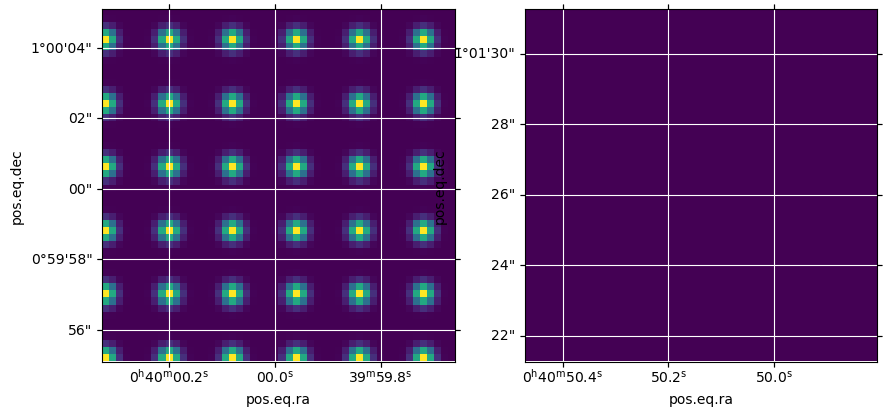

In [3]:
#define position and site for the observation
ra=10.
dec=1.
time="2023-03-20T16:00:00"
site='ctio'
loc = EarthLocation.of_site(site)
distance = 50.#*u.au #49.99939666

#create ICRS image
nx=50
ny=50
icrs = create_image(ra, dec, time=time, nx=nx, ny=ny)

#create blank EBD image
ebd = create_image(0., 0., nx=nx, ny=ny, source_separation=None)
ebd.wcs = fit_wcs(icrs, distance, time, loc)
plot_images(icrs, ebd)



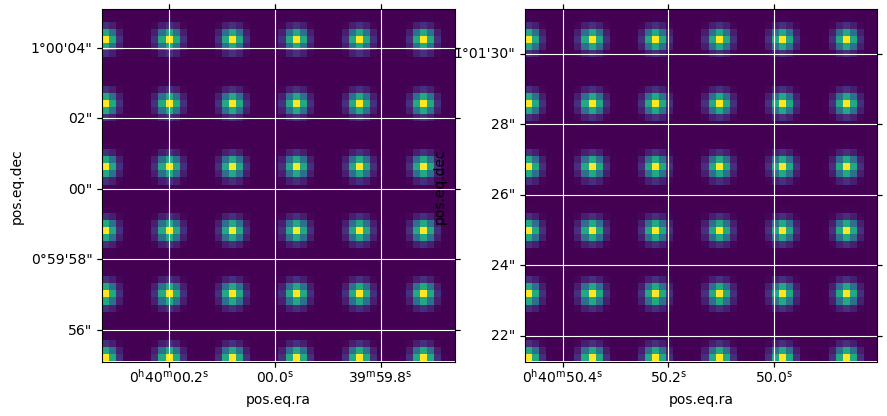

In [4]:
# apply pixel by pixel transform from ICRS to EBD
#xy = get_transformed_pixels(icrs.wcs, ebd.wcs, time, loc, distance)
#_xy = np.array(xy).T

ebd_crude = ebd.copy()
xy = get_transformed_pixels(icrs.wcs, ebd.wcs, time, loc, distance)
_xy = np.array(xy).T
it = np.nditer(ebd_crude.data, flags=['multi_index'])
for i,_x in enumerate(it):
    if _xy[i][0]>=0 and _xy[i][0]<nx and _xy[i][1]>=0 and _xy[i][1]<ny:
        ebd_crude.data[it.multi_index] = icrs.data[_xy[i][0],_xy[i][1]]

plot_images(icrs, ebd_crude)

In [7]:
# given a distance calculate an affine transform from ICRS to EBD
affine, transform = fit_affine_transform(icrs, ebd, time, loc, distance)
print (affine)

rms error: 4.5346829433249934e-07
[[ 1.01976439e+00 -6.48892356e-05  0.00000000e+00]
 [ 6.64607285e-05  1.01975021e+00  0.00000000e+00]
 [ 1.11983426e-02  4.86118773e-03  1.00000000e+00]]


In [8]:
#define new wcs (parallax corrected)
wcs_trans = WCS(naxis=2)
center = np.vstack([icrs.wcs.wcs.crval,icrs.wcs.wcs.crval])
print (center)
print(transform(center))
wcs_trans.wcs.cdelt = np.array([-0.000055555555556,0.000055555555556])
wcs_trans.wcs.crval = transform(center)[0]
wcs_trans.wcs.ctype = ["RA---TAN", "DEC--TAN"]
# note this is hand coded and might override the values for cdelt
wcs_trans.wcs.pc = np.dot(icrs.wcs.wcs.pc, [[ 1.01976438e+00, -6.48904377e-05], [ 6.64438678e-05,  1.01975021e+00]])

wcs_trans.pixel_shape = (nx,ny)
wcs_trans.wcs.crpix = [nx/2,ny/2]

world = wcs_trans.wcs_pix2world(np.array([[0, 0], [nx, 0], [nx, ny], [0, ny],]), 0)

#check the EBD corner coordinates are the same as the inputs
print (world)

[[10.  1.]
 [10.  1.]]
[[10.20890869  1.0239625 ]
 [10.20890869  1.0239625 ]]
[[10.2102685   1.02260275]
 [10.20743537  1.02260293]
 [10.20743555  1.02543557]
 [10.21026869  1.02543539]]


In [9]:
wcs_trans

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 10.208908688163257  1.0239625042112928  
CRPIX : 25.0  25.0  
PC1_1 PC1_2  : 1.01976438  -6.48904377e-05  
PC2_1 PC2_2  : 6.64438678e-05  1.01975021  
CDELT : -5.5555555556e-05  5.5555555556e-05  
NAXIS : 50  50

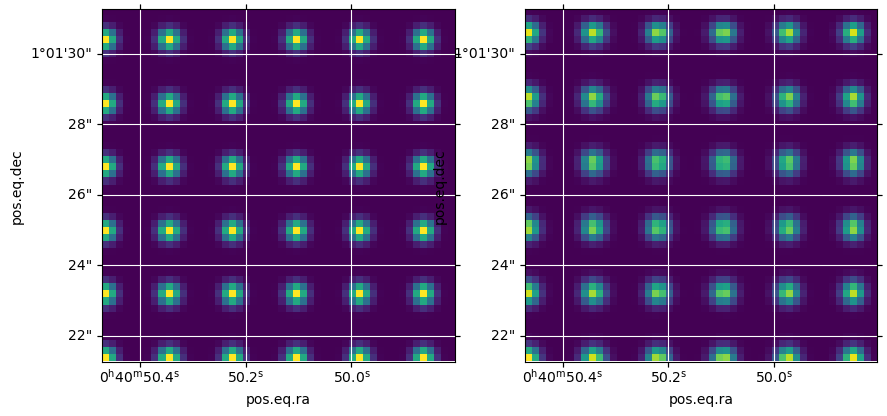

In [10]:
#reproject an image
from reproject import reproject_interp
#replace ICRS wcs with transformed WCS then reproject
old_wcs= icrs.wcs
icrs.wcs = wcs_trans
new_ebd, footprint = reproject_interp(icrs, ebd.wcs, shape_out=(nx,ny))
new_ebd = CCDData(new_ebd, unit="adu")
new_ebd.wcs=ebd.wcs
plot_images(ebd_crude, new_ebd)
